In [ ]:
import numpy as np
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import torch
import scipy
from ansatz import *
from cost import *
from tqdm import tqdm
from Discriminator import *

In [ ]:
_N_QUBITS=8
_L_DEPTH =2
_NR_SHOTS = 2000
_ALL_2_ALL = True
_USE_ROWS = False
_I_MAX = 30
if _ALL_2_ALL:
    _NR_PARAMS = int(_L_DEPTH*(2*_N_QUBITS+ _N_QUBITS * (_N_QUBITS - 1) / 2))
else:
    _NR_PARAMS = int(_L_DEPTH*(2*_N_QUBITS+ _N_QUBITS - 1))
_THETA_INIT = torch.randn(size=(_NR_PARAMS,)).tolist()


In [ ]:
torch.manual_seed(0)
test_weights = torch.bernoulli(torch.abs(torch.nn.Linear(in_features=100,out_features=_N_QUBITS,bias=False).weight))

In [ ]:
my_cost = get_cost(_x_train=test_weights,
                   _nr_qubits=_N_QUBITS,
                   _layer_depth=_L_DEPTH,
                   _shots=_NR_SHOTS,
                   _all_2_all=_ALL_2_ALL,
                   _use_rows=_USE_ROWS)

counter = 0
losses = []
def my_callback(params):
    global counter, losses
    backend = qiskit.Aer.get_backend('aer_simulator')
    q_circuit = ansatz(_theta=params,
                       _nr_qubits=_N_QUBITS,
                       _layer_depth=_L_DEPTH,
                       _all_2_all=_ALL_2_ALL,
                       _uniform_warm_start=True)
    transpiled_qpe = qiskit.transpile(q_circuit, backend)
    assembled_qobj = qiskit.assemble(transpiled_qpe, shots=_NR_SHOTS)
    measurements = backend.run(assembled_qobj).result().get_counts()
    losses.append(NLL_cost(x_train=test_weights,
                    x_model=measurements,
                    eps=1.0e-8,
                    use_rows=True).item())
    counter += 1
    print("iteration: ", counter, "/", _I_MAX)


In [ ]:
my_result = scipy.optimize.minimize(fun=my_cost, x0=_THETA_INIT, method="COBYLA", callback= my_callback, options={'disp':True, 'maxiter': _I_MAX})

iteration:  1 / 30
iteration:  2 / 30
iteration:  3 / 30
iteration:  4 / 30
iteration:  5 / 30
iteration:  6 / 30
iteration:  7 / 30
iteration:  8 / 30
iteration:  9 / 30
iteration:  10 / 30
iteration:  11 / 30
iteration:  12 / 30
iteration:  13 / 30
iteration:  14 / 30
iteration:  15 / 30
iteration:  16 / 30
iteration:  17 / 30
iteration:  18 / 30
iteration:  19 / 30
iteration:  20 / 30
iteration:  21 / 30
iteration:  22 / 30
iteration:  23 / 30
iteration:  24 / 30
iteration:  25 / 30
iteration:  26 / 30
iteration:  27 / 30
iteration:  28 / 30
iteration:  29 / 30
iteration:  30 / 30

   Return from subroutine COBYLA because the MAXFUN limit has been reached.

   NFVALS =   30   F = 1.670115E+02    MAXCV = 0.000000E+00
   X =-1.637359E+00  -7.029536E-01   1.288113E-01   4.899911E-02  -3.311958E-01
      -2.524549E-01   1.224130E+00   4.490037E-01   6.494808E-01  -8.055359E-01
       1.189067E+00  -6.777855E-01  -5.745025E-01   1.251334E-01   7.476850E-01
      -1.057949E+00  -1.861497E

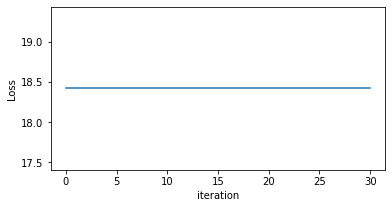

In [ ]:
iterations = [i for i in range(len(losses))]
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(6,3))
ax.plot(iterations,losses)
ax.set_xlabel("iteration"), ax.set_ylabel("Loss")
plt.show()

In [48]:
my_circuit=ansatz(_theta = my_result['x'],
                  _nr_qubits=_N_QUBITS,
                  _layer_depth=_L_DEPTH,
                  _all_2_all=_ALL_2_ALL,
                  _uniform_warm_start=True)

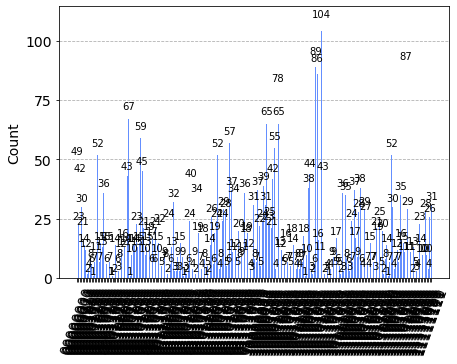

In [49]:
aer_sim = qiskit.Aer.get_backend('aer_simulator')
shots = 4096
t_qpe = qiskit.transpile(my_circuit, aer_sim)
qobj = qiskit.assemble(t_qpe, shots=shots)
results = aer_sim.run(qobj).result()
answer = results.get_counts()
plot_histogram(answer)

In [7]:
def sample_qcirc(params,
                 _nr_samples, 
                 _nr_qubits,
                 _layer_depth,
                 _all_2_all,
                 _uniform_warm_start):
    backend = qiskit.Aer.get_backend('aer_simulator')
    q_circuit = ansatz(_theta=params,
                       _nr_qubits=_nr_qubits,
                       _layer_depth=_layer_depth,
                       _all_2_all=_all_2_all,
                       _uniform_warm_start=_uniform_warm_start)
    transpiled_qpe = qiskit.transpile(q_circuit, backend)
    assembled_qobj = qiskit.assemble(transpiled_qpe, shots=_nr_samples)
    measurements = backend.run(assembled_qobj).result().get_counts()
    states = []
    for state in list(measurements.keys()):
        _state = []
        for _qbit in state:
            _state.append(float(_qbit))
        for occurrences in range(measurements[state]):
            states.append(_state)
    return torch.tensor(states)

In [ ]:
sample_q